# Identifying Bayesian Mixture Models in PyMC3
(port of Stan case study http://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html)

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import theano.tensor as tt
import theano

%config InlineBackend.figure_format = 'retina'

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


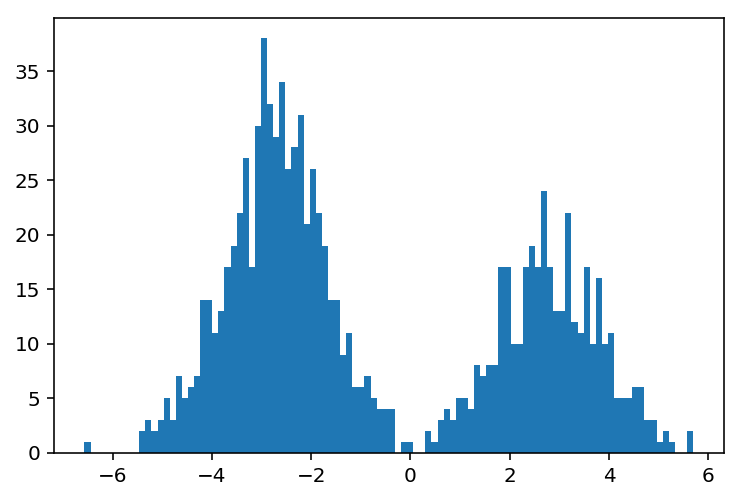

In [2]:
mu0 = np.asarray([-2.75, 2.75])
sigma0 = np.asarray([1, 1])
lam = 0.4

N = 1000
z = np.random.binomial(1, lam, size=(N,))
y = np.random.normal(loc=mu0[z], scale=sigma0[z])

plt.hist(y, 100);

## A Degenerate Implementation

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu, theta]
100%|██████████| 2000/2000 [00:13<00:00, 146.28it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


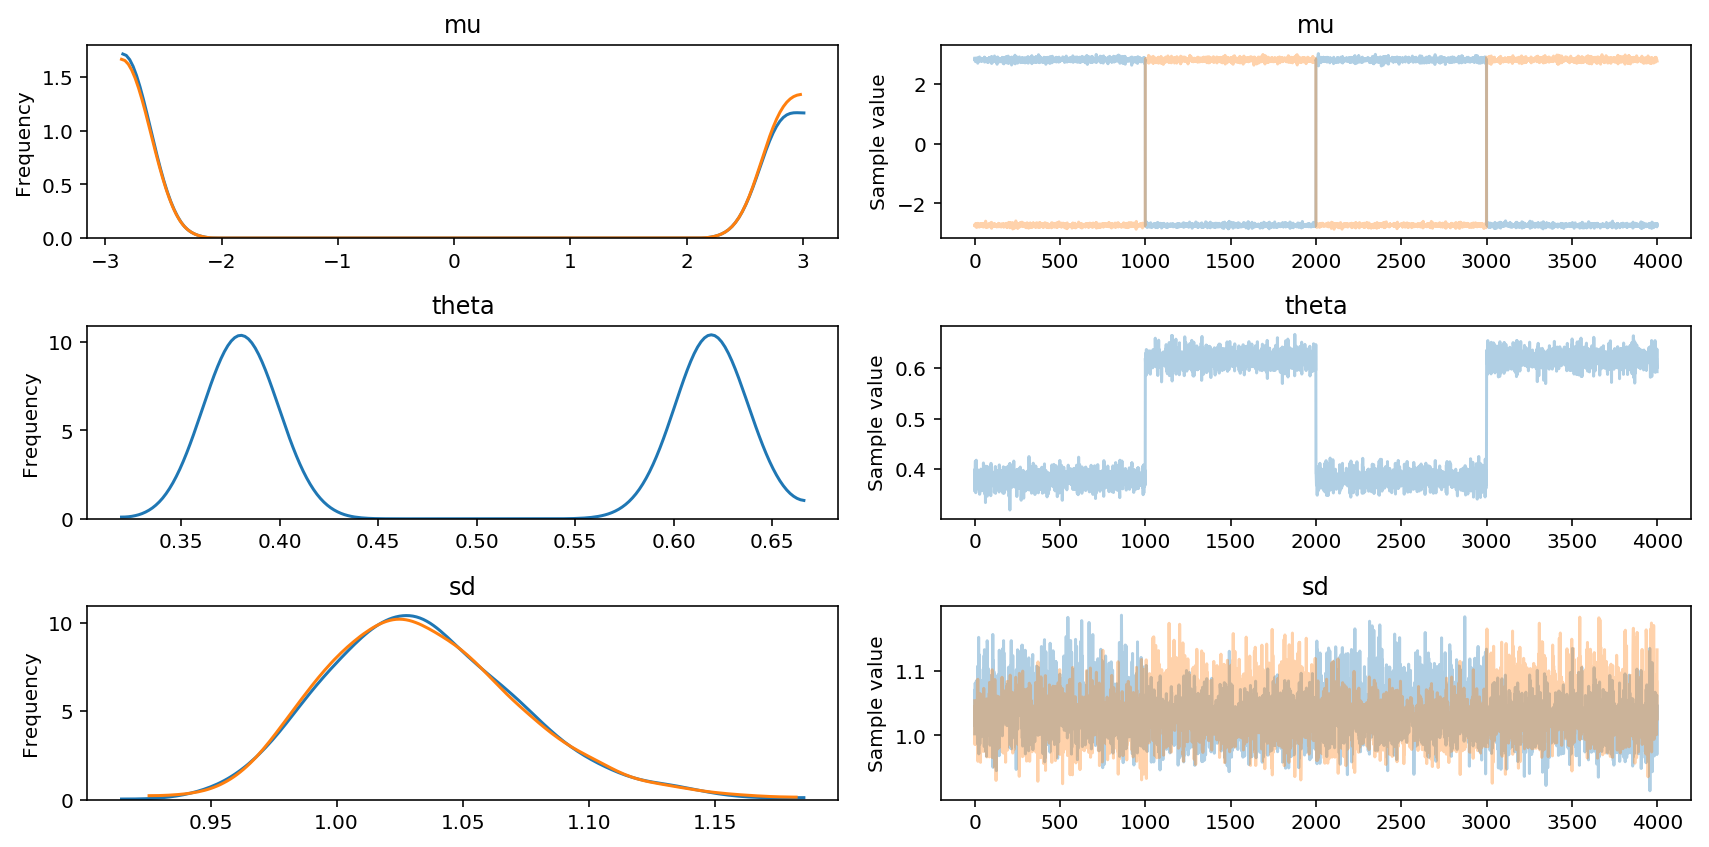

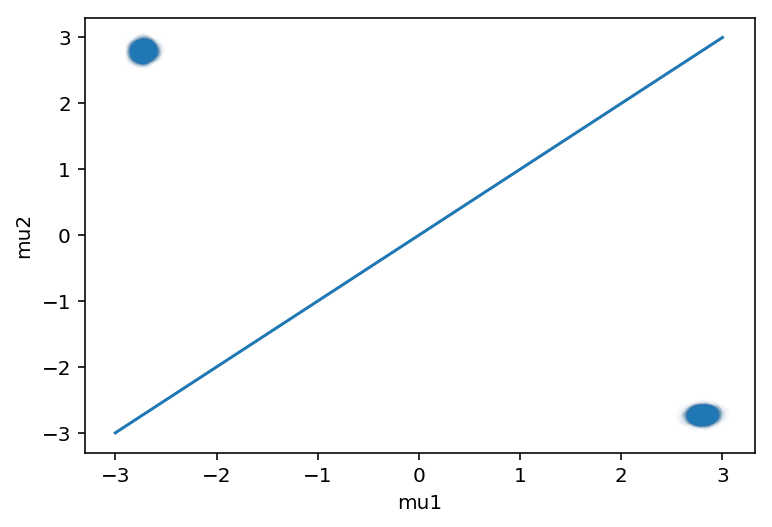

In [6]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2)
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace, combined=True);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

## Non-exchangeable Priors

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu1, mu0, theta]
100%|██████████| 2000/2000 [00:13<00:00, 147.77it/s]


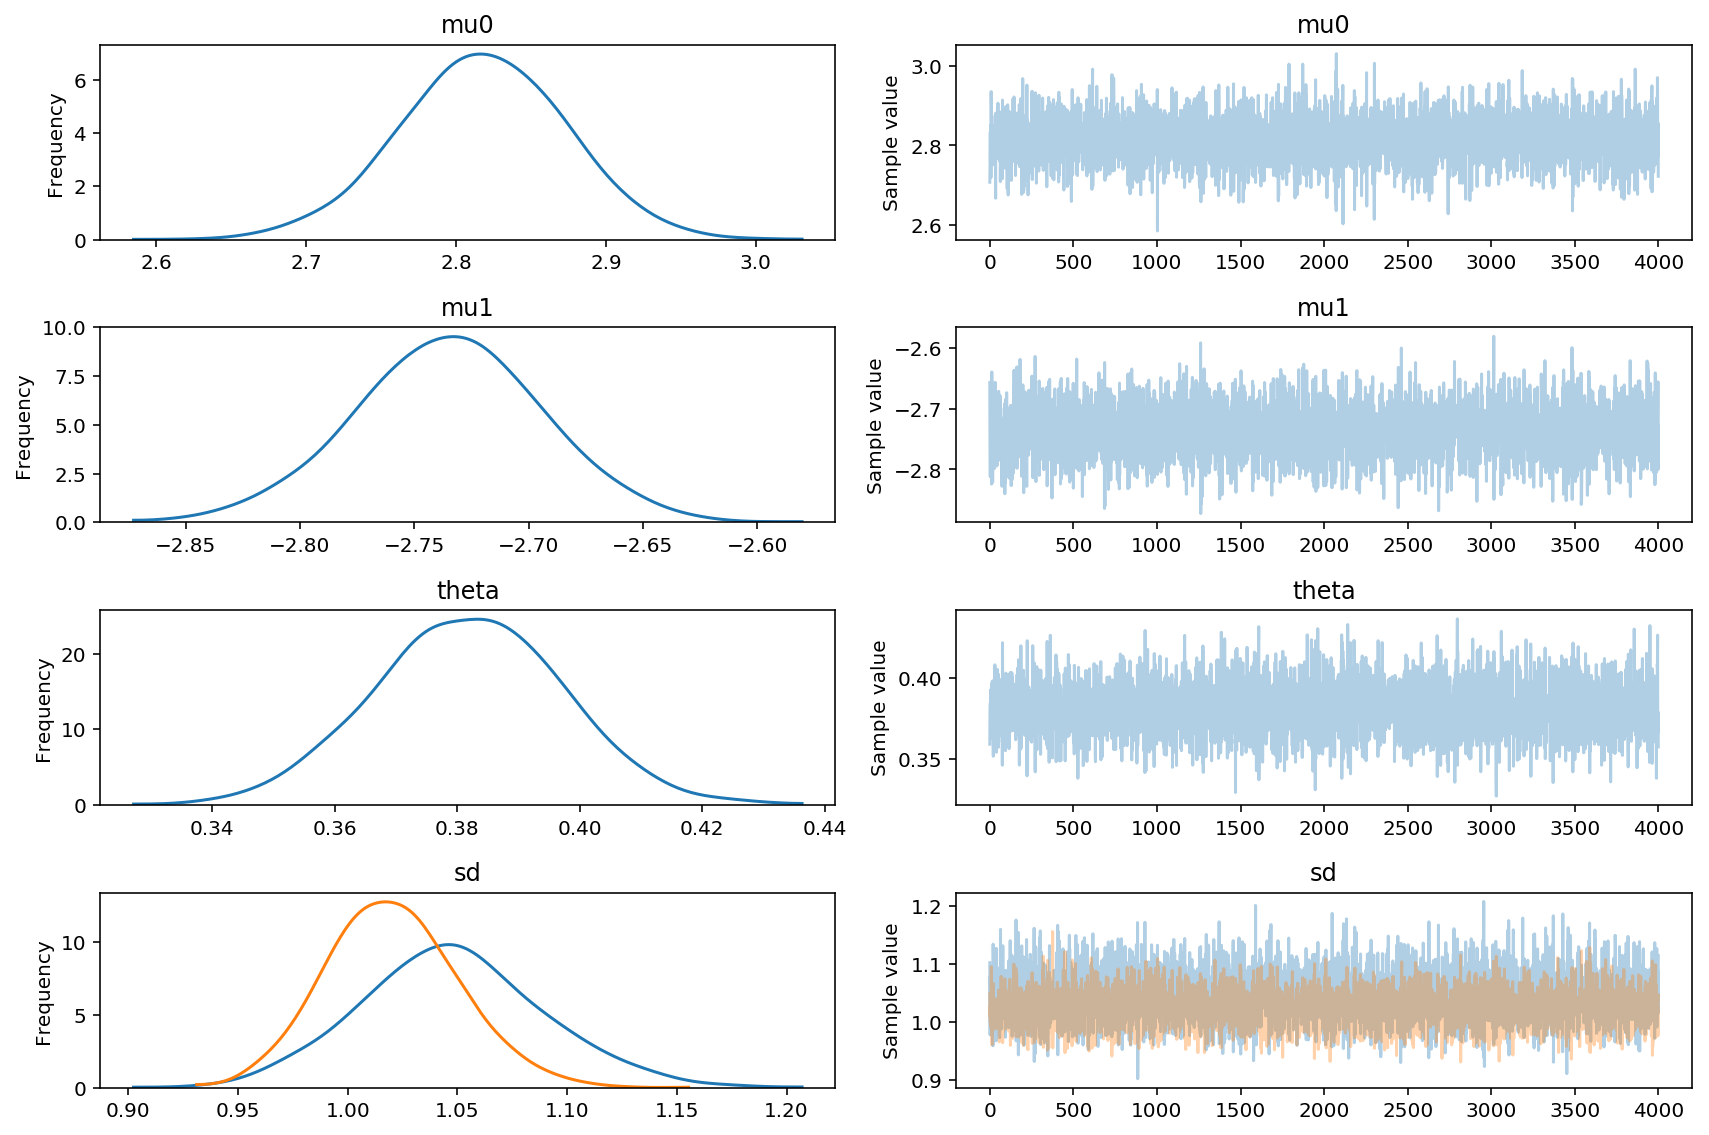

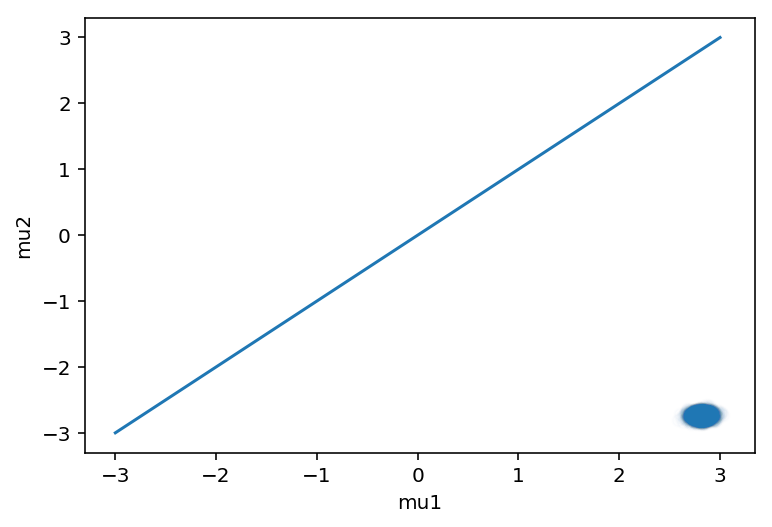

In [7]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu0 = pm.Normal('mu0', 4, .5)
    mu1 = pm.Normal('mu1', -4, .5)
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, [mu0, mu1], sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace, combined=True);
plt.figure()
plt.scatter(trace['mu0'], trace['mu1'], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

## Enforcing an Ordering

In [8]:
import pymc3.distributions.transforms as tr

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu, theta]
100%|██████████| 2000/2000 [00:29<00:00, 67.61it/s] 


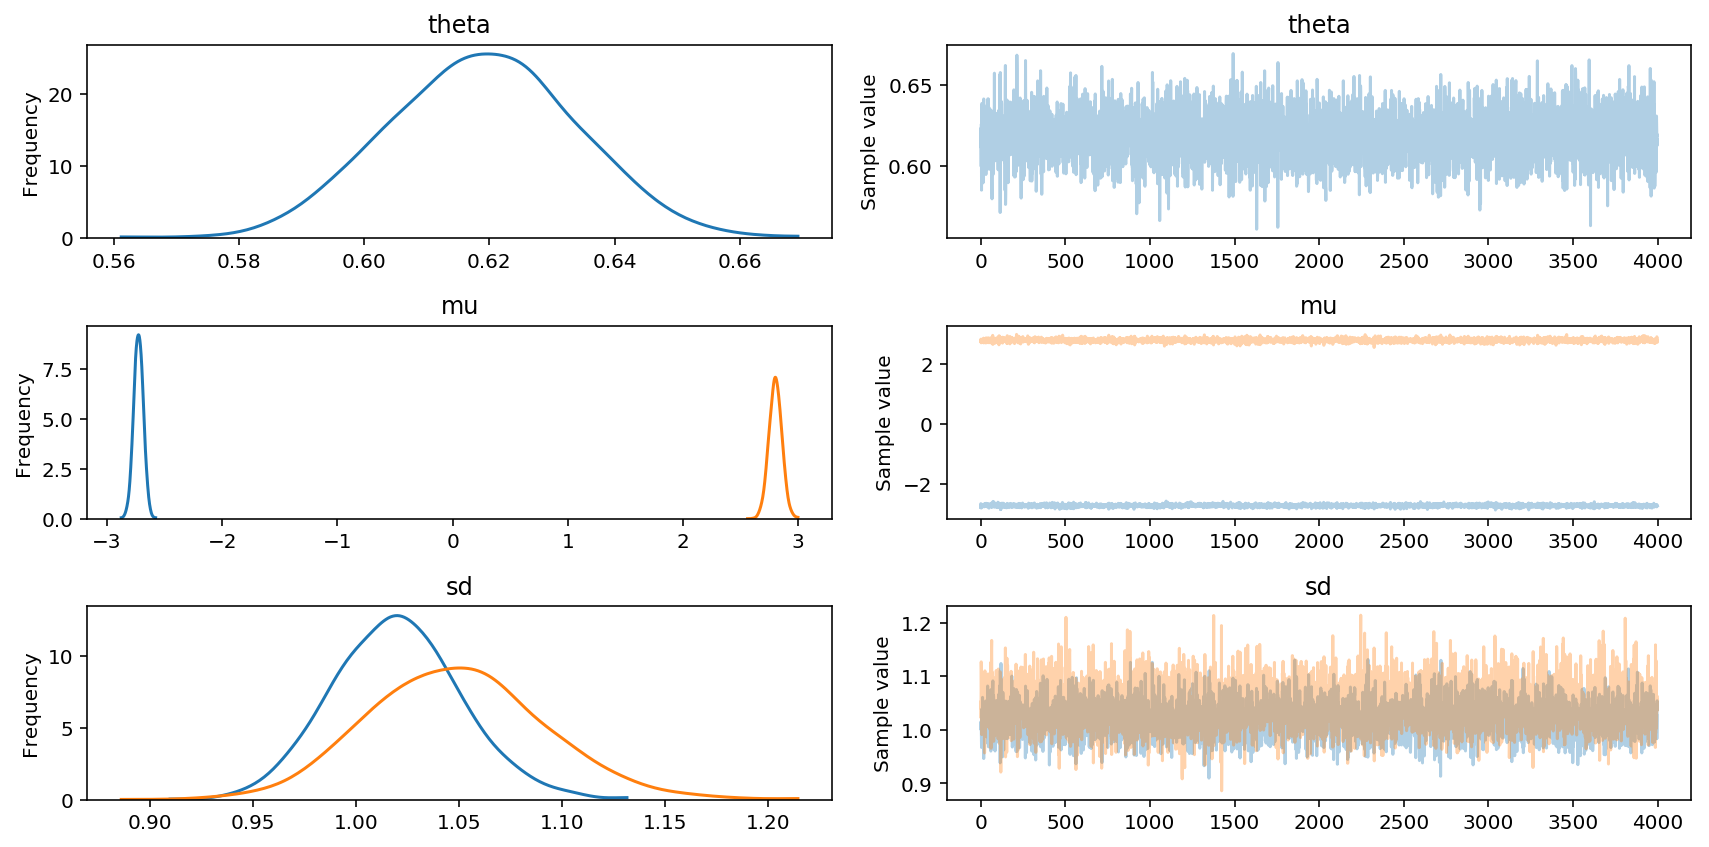

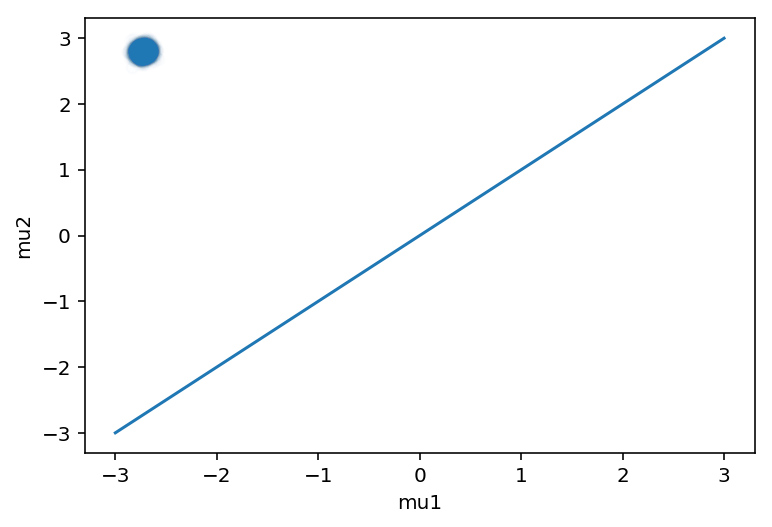

In [9]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2, transform=tr.ordered,
                    testval=[0.1, 0.2])
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace, combined=True);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

## Enforcing an Ordering (Using potential)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu, theta]
100%|██████████| 2000/2000 [00:13<00:00, 153.66it/s]


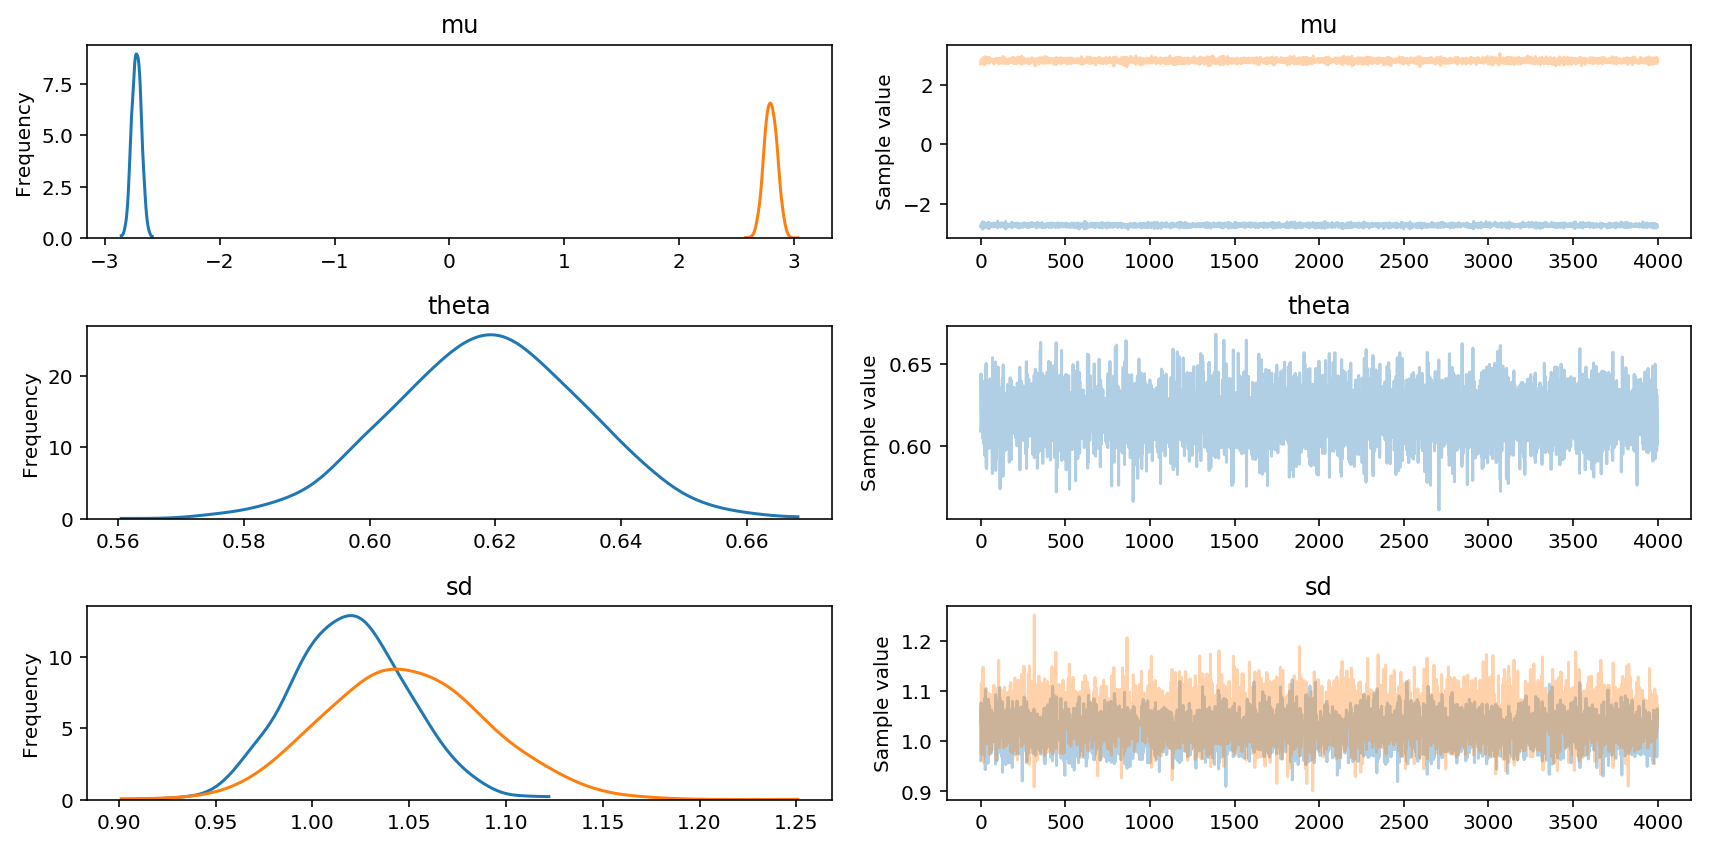

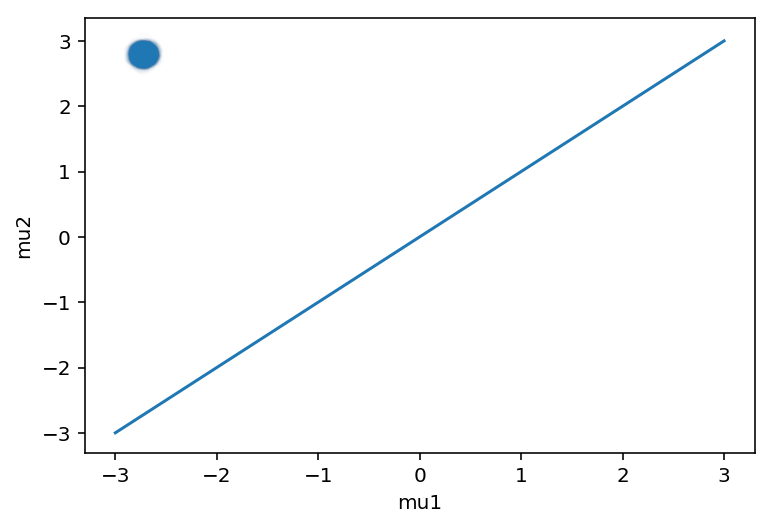

In [11]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2, testval=[0.1, 0.2])
    pm.Potential('ordered', tt.switch(mu[1]-mu[0] < 0, -np.inf, 0))
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace, combined=True);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

## Singular Components and Computational Issues

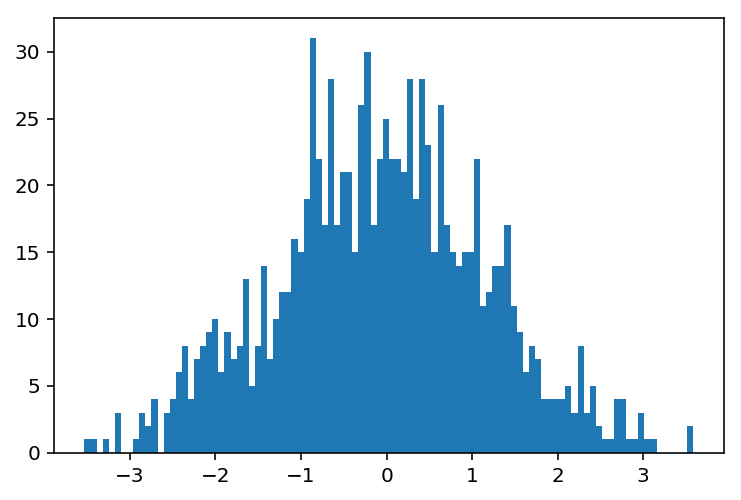

In [12]:
mu0 = np.asarray([-0.75, 0.75])
sigma0 = np.asarray([1, 1])
lam = 0.4

N = 1000
z = np.random.binomial(1, lam, size=(N,))
y = np.random.normal(loc=mu0[z], scale=sigma0[z])

plt.hist(y, 100);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:32<00:00, 60.69it/s]
The number of effective samples is smaller than 25% for some parameters.


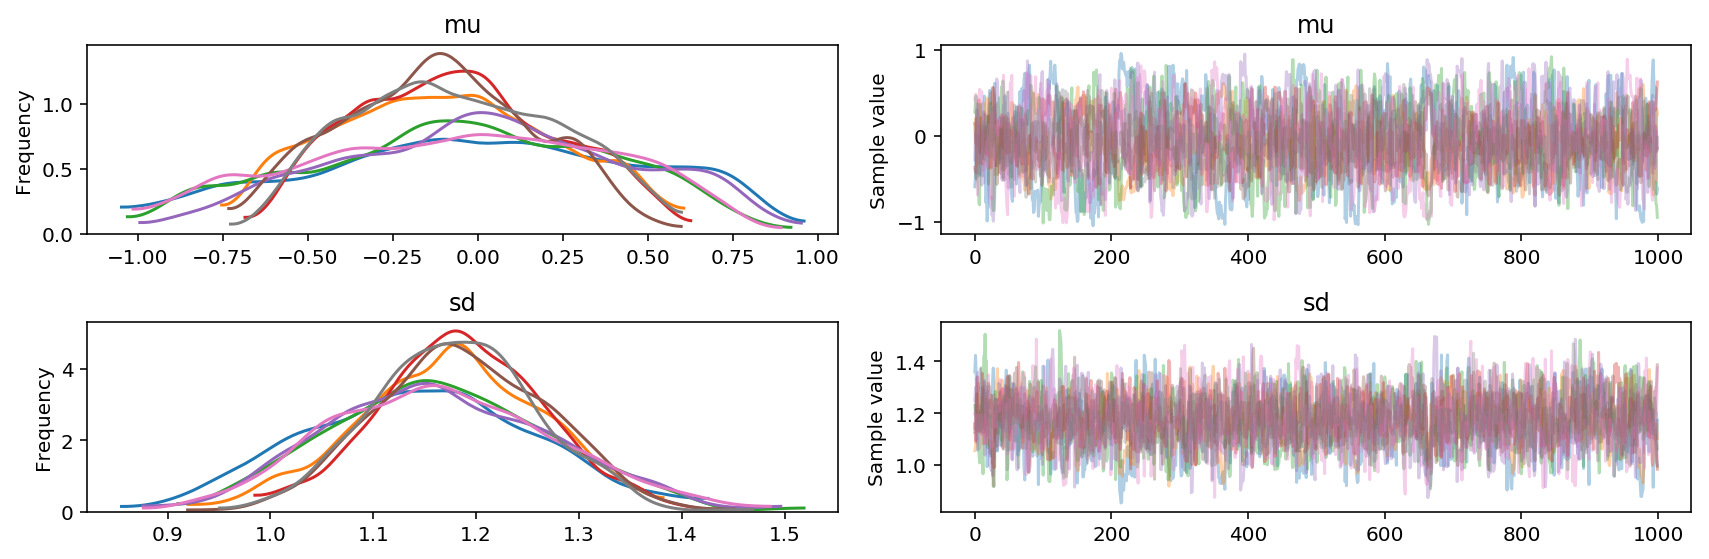

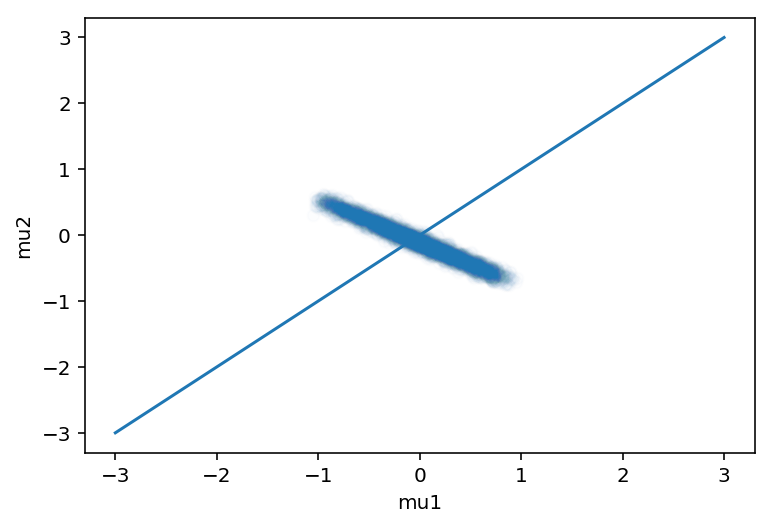

In [14]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5., observed=lam)
    mu = pm.Normal('mu', 0, 2, shape=2)
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:34<00:00, 57.75it/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:30<00:00, 64.63it/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:26<00:00, 76.24it/s]
The number of effective samples is smaller than 25% for some parameters.


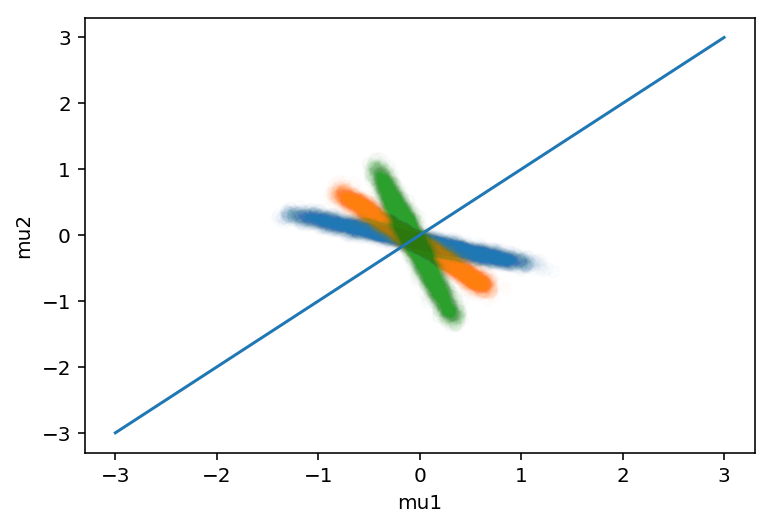

In [15]:
from sampled import sampled
@sampled
def gmix_model(theta):
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2)
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)

plt.figure()
for lam in [.25, .5, .75]:
    with gmix_model(theta=lam):
        trace = pm.sample(1000, tune=1000, njobs=4)
    
    plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
    
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu, theta]
100%|██████████| 2000/2000 [00:44<00:00, 44.71it/s]
The number of effective samples is smaller than 25% for some parameters.


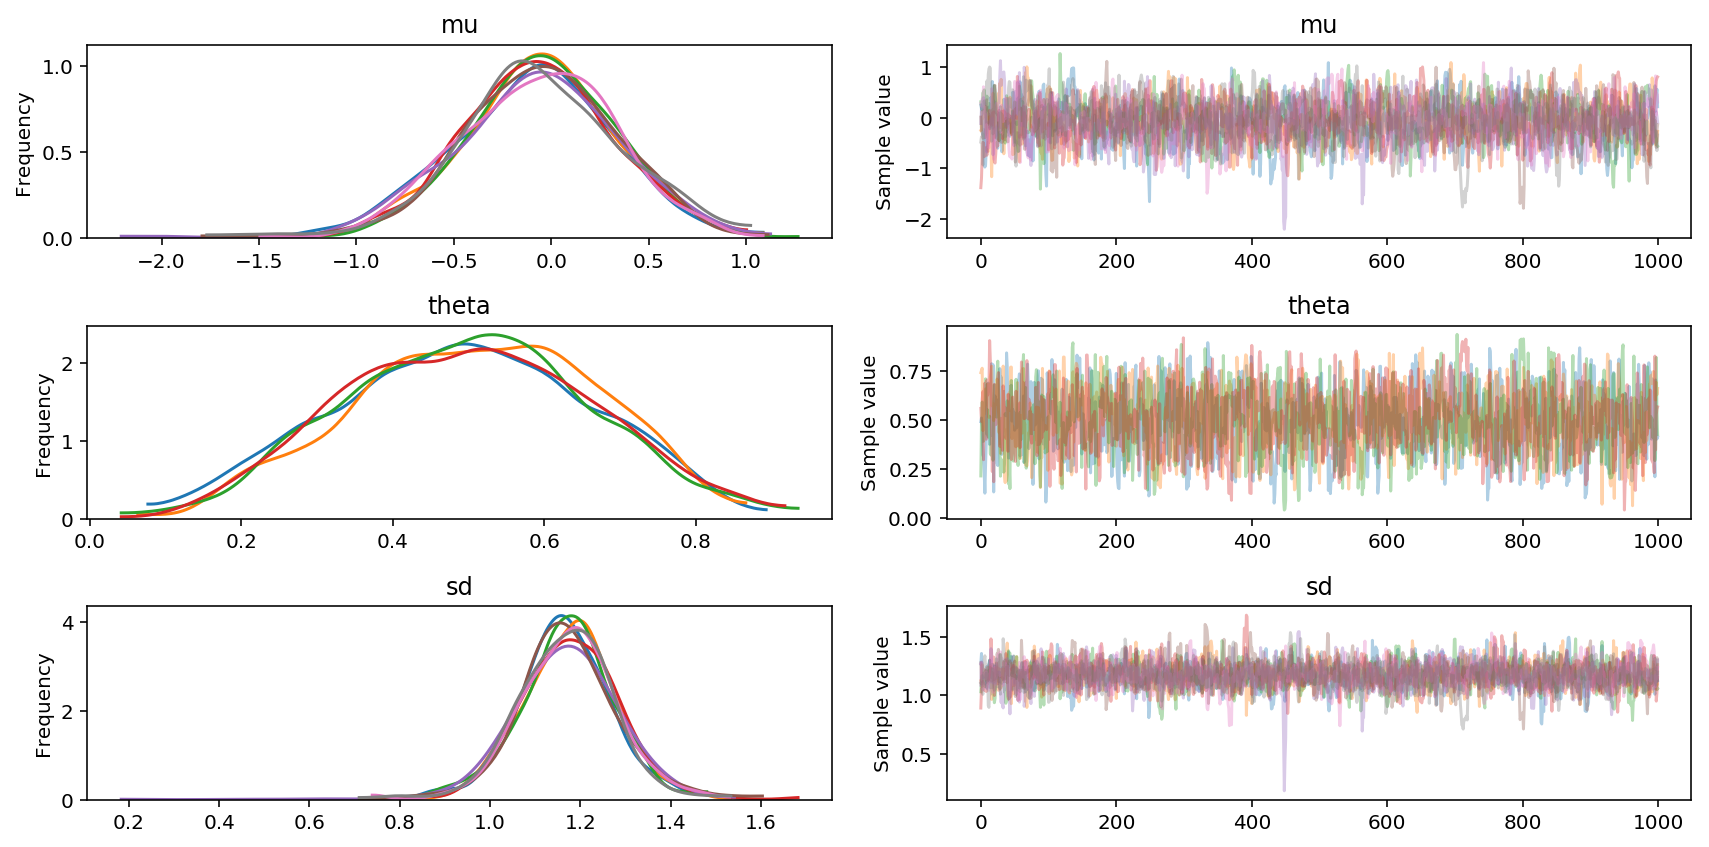

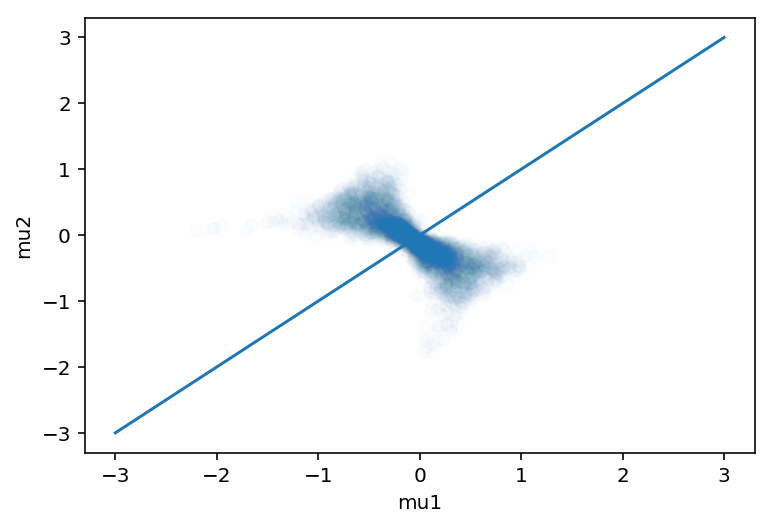

In [16]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2)
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu, theta]
100%|██████████| 2000/2000 [01:03<00:00, 31.62it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6619737014954173, but should be close to 0.8. Try to increase the number of tuning steps.
There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3104487088325319, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7011001854046185, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rub

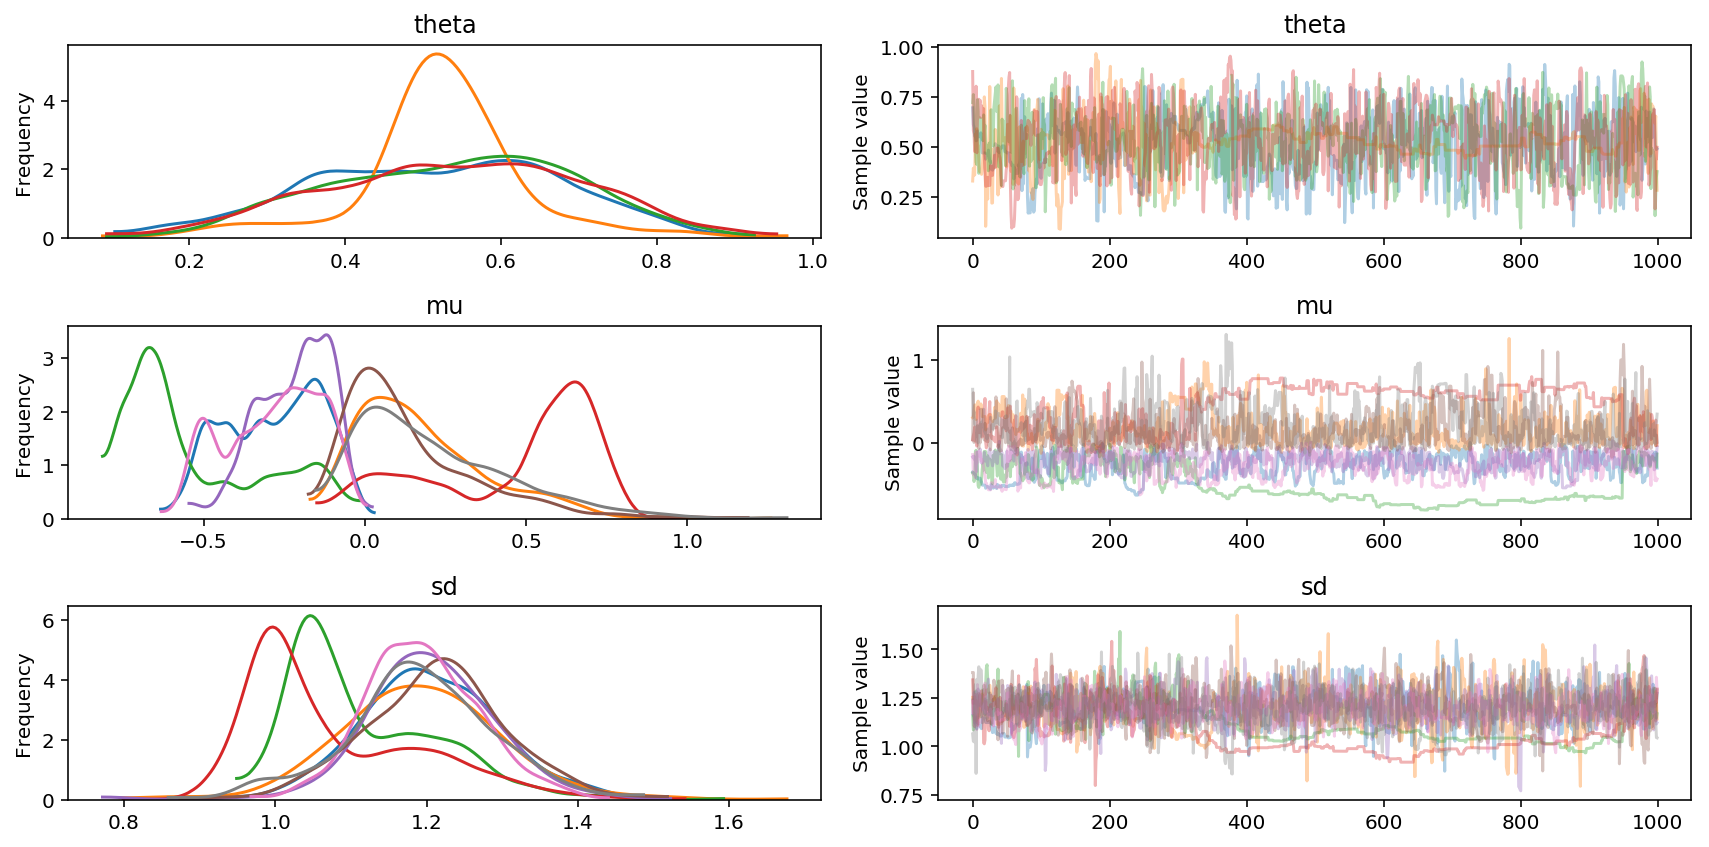

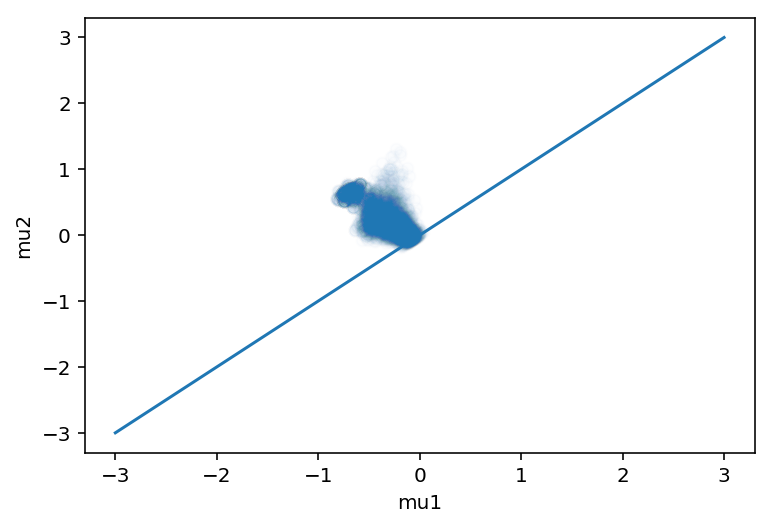

In [19]:
with pm.Model() as model:
    theta = pm.Beta('theta', 5., 5.)
    mu = pm.Normal('mu', 0, 2, shape=2, transform=tr.ordered,
                    testval=[0.1, 0.2])
    sd = pm.HalfNormal('sd', 2, shape=2)
    w = tt.stack([theta, 1.-theta])
    obs = pm.NormalMixture('x_obs', w, mu, sd=sd, observed=y)
    trace = pm.sample(1000, tune=1000, njobs=4)
pm.traceplot(trace);
plt.figure()
plt.scatter(trace['mu'][:,0], trace['mu'][:,1], alpha=.01)
plt.plot([-3, 3], [-3, 3])
plt.xlabel('mu1')
plt.ylabel('mu2');